### Train and save a model

In [1]:
import pickle
import sys

# adapt paths
sys.path.append("/home/cctrotte/krauthammer/eustar_clean/benchmark_VAE/")
sys.path.append("/home/cctrotte/krauthammer/eustar_clean/benchmark_VAE/src/")


from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models import BetaVAEgpCondInd
from pythae.models import (
    BetaVAEgpCondIndConfig,
)
from pythae.models.beta_vae_gp.encoder_decoder import (
    Indep_MLP_Decoder,
    Guidance_Classifier,
    LSTM_Encoder,
    LSTM_Retrodiction_Decoder,
)

from pythae.ssc.utils import (
    load_cv,
    get_classifier_config,
    remove_short_samples,
)

from pythae.models.beta_vae_gp.classifier_config import (
    EncoderDecoderConfig,
    PriorLatentConfig,
    DecoderConfig,
)
from pythae.models.beta_vae_gp.prior_latent import PriorLatent

import numpy as np
import torch
import random

from pythae.ssc.plots import plot_losses

In [2]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"

# adapt path
data_path = "/home/cctrotte/krauthammer/eustar_clean/fake_data/processed/"
name = "_ml4h"

# load bodies and cohorts, they have to be generate first by running the ssc/create_cv.py script
with open(data_path + "bodies_" + name + ".pkl", "rb") as file:
    bodies = pickle.load(file)
with open(data_path + "cohorts_" + name + ".pkl", "rb") as file:
    cohorts = pickle.load(file)

(
    data_train_folds,
    data_valid_folds,
    data_test_folds,
    varNames,
    varSplits,
    xyt0,
    xyt1,
) = load_cv(data_path, name=name)

# variable names
var_names0 = [var.name for var in (bodies[0].variables + bodies[0].labels)]
var_weights0 = [
    var.class_weight_norm for var in (bodies[0].variables + bodies[0].labels)
]

names_x0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "x"]
names_y0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "y"]
weights_x0 = [vW for i, vW in enumerate(var_weights0) if xyt0[i] == "x"]
weights_y0 = [vW for i, vW in enumerate(var_weights0) if xyt0[i] == "y"]

kinds_x0 = [
    var.kind
    for var in (bodies[0].variables + bodies[0].labels)
    for nx in names_x0
    if var.name == nx
]
kinds_y0 = [
    var.kind
    for var in (bodies[0].variables + bodies[0].labels)
    for nx in names_y0
    if var.name == nx
]
splits_x0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "x"]
splits_y0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "y"]
splits_s0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "s"]
# remove samples of length 0 or 1
for i, (data_train, data_valid, data_test) in enumerate(
    zip(data_train_folds, data_valid_folds, data_test_folds)
):
    data_train, data_valid, data_test = remove_short_samples(
        data_train, data_valid, data_test
    )

    data_train_folds[i] = data_train
    data_valid_folds[i] = data_valid
    data_test_folds[i] = data_test

input_size = sum(splits_x0)

static_size = sum(splits_s0)
latent_dim = 21
model_name = "VAE"

params = {
    "dropout": 0.1,
    "lstm_hidden_size": 100,
    "num_lstm_layers": 1,
    "hidden_dims_enc": [100, 100],
    "hidden_dims_emb_dec": [100],
    "hidden_dims_log_var_dec": [100],
    "classif_layers": [40],
}

# can be changed to train different models
sample_ = True
fixed_variance = False

# to create classifier configs. Specify each classifier name, variables to predict in y, z dimensions to use and architecture of the classifier
classifier_config = {
    "lung_inv": {
        "y_names": ["LUNG_ILD_involvement_or"],
        "z_dims": np.arange(0, 7),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "lung_stage": {
        "y_names": ["LUNG_ILD_stage_or"],
        "z_dims": np.arange(0, 7),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "heart_inv": {
        "y_names": ["HEART_involvement_or"],
        "z_dims": np.arange(7, 14),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "heart_stage": {
        "y_names": ["HEART_stage_or"],
        "z_dims": np.arange(7, 14),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "arthritis_inv": {
        "y_names": ["ARTHRITIS_involvement_or"],
        "z_dims": np.arange(14, 21),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "arthritis_stage": {
        "y_names": ["ARTHRITIS_stage_or"],
        "z_dims": np.arange(14, 21),
        "layers": params["classif_layers"],
        "type": "static",
    },
}
# weights for the different losses
beta = 0.01
w_class = {
    "lung_inv": 0.2,
    "lung_stage": 0.2,
    "heart_inv": 0.2,
    "heart_stage": 0.2,
    "arthritis_inv": 0.2,
    "arthritis_stage": 0.2,
}

w_recon = 1
w_class_pred = {
    "lung_inv": 0.2,
    "lung_stage": 0.2,
    "heart_inv": 0.2,
    "heart_stage": 0.2,
    "arthritis_inv": 0.2,
    "arthritis_stage": 0.2,
}


classifier_configs = get_classifier_config(names_y0, splits_y0, classifier_config)

encoder_config = EncoderDecoderConfig.from_dict(
    {
        "input_dim": input_size + static_size,
        "output_dim": latent_dim,
        "latent_dim": latent_dim,
        "hidden_dims": params["hidden_dims_enc"],
        "cond_dim_time_input": 1,
        "lstm_": True,
        "lstm_hidden_size": params["lstm_hidden_size"],
        "num_lstm_layers": params["num_lstm_layers"],
        "device": device,
        "dropout": params["dropout"],
        "predict": True,
    }
)
decoder_config = DecoderConfig.from_dict(
    {
        "latent_dim": latent_dim,
        "output_dim": input_size,
        "fixed_variance": fixed_variance,
        "hidden_dims": [],
        "hidden_dims_emb": params["hidden_dims_emb_dec"],
        "hidden_dims_log_var": params["hidden_dims_log_var_dec"],
        "cond_dim_time_latent": 1,
        "cond_dim_static_latent": static_size,
        "lstm_": False,
        "dropout": params["dropout"],
        "device": device,
    }
)

prior_config = PriorLatentConfig.from_dict(
    {
        "input_dim": 1 + static_size,
        "latent_dim": latent_dim,
        "hidden_dims": [50],
        "device": device,
        "dropout": params["dropout"],
    }
)

to_reconstruct_x = [(name, index, True) for index, name in enumerate(names_x0)]

to_reconstruct_y = [(name, index, True) for index, name in enumerate(names_y0)]
model_config = BetaVAEgpCondIndConfig(
    input_dim=(input_size,),
    sample=sample_,
    latent_dim=latent_dim,
    w_class=w_class,
    w_recon=w_recon,
    beta=beta,
    w_class_pred=w_class_pred,
    missing_loss=True,
    latent_prior_noise_var=1,
    classifier_config=classifier_configs,
    encoder_config=encoder_config,
    decoder_config=decoder_config,
    prior_config=prior_config,
    splits_x0=splits_x0,
    kinds_x0=kinds_x0,
    splits_y0=splits_y0,
    kinds_y0=kinds_y0,
    names_x0=names_x0,
    weights_x0=weights_x0,
    weights_y0=weights_y0,
    to_reconstruct_x=to_reconstruct_x,
    to_reconstruct_y=to_reconstruct_y,
    device=device,
    predict=True,
    retrodiction=False,
    progression=False,
)

k = 0
print(f"Training on fold {k}")

output_dir = "saved_models/model_fold_" + str(k) + "/"
config = BaseTrainerConfig(
    output_dir=output_dir,
    learning_rate=1e-3,
    batch_size=100,
    num_epochs=50,
    customized=True,
)

my_encoder = LSTM_Encoder(encoder_config)

if decoder_config.lstm_:
    my_decoder = LSTM_Retrodiction_Decoder(decoder_config)
else:
    my_decoder = Indep_MLP_Decoder(decoder_config)

if prior_config is not None:
    prior_latent = PriorLatent(prior_config)
else:
    prior_latent = None

my_classifiers = [
    Guidance_Classifier(config) for config in model_config.classifier_config
]

model = BetaVAEgpCondInd(
    model_config=model_config,
    encoder=my_encoder,
    decoder=my_decoder,
    classifiers=my_classifiers,
    prior_latent=prior_latent,
)

pipeline = TrainingPipeline(training_config=config, model=model)

Training on fold 0


In [3]:
# train model
pipeline(train_data=data_train_folds[k], eval_data=data_valid_folds[k])

Using customized Base Trainer

Model passed sanity check !

Created saved_models/model_fold_0/BetaVAEgpCondInd_training_2023-09-01_07-59-08. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 1/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.4423
Train loss CV: 3.4423
Train losses: tensor([2.1959, 0.9430, 0.0059, 0.1414, 0.2824, 0.1186, 0.2874, 0.1399, 0.2774])
Train loss CE all: 0.7703 Train loss nll all: 1.1373
Train losses unw: tensor([7.7706, 0.9430, 0.5927, 0.7068, 1.4118, 0.5929, 1.4368, 0.6996, 1.3870])
Train losses pred: tensor([2.1895, 0.9430, 0.1417, 0.2827, 0.1187, 0.2860, 0.1399, 0.2774])
Train loss CE recon pred: 0.7713 Train loss nll recon pred: 1.1362
Train losses unw pred: tensor([7.1752, 0.9430, 0.7084, 1.4137, 0.5936, 1.4298, 0.6996, 1.3870])
Eval loss: 3.4353
Eval loss CV: 3.4353
Eval losses: tensor([2.2008, 0.9597, 0.0081, 0.1343, 0.2799, 0.1146, 0.2944, 0.1389, 0.2710])
Eval loss CE recon: 0.7737 Eval loss nll recon: 1.1689
Eval losses unw: tensor([7.9300, 0.9597, 0.8051, 0.6713, 1.3996, 0.5729, 1.4721, 0.6945, 1.3548])
Eval losses pred: tensor([2.1987, 0.9642, 0.1354, 0.2797, 0.1158, 0.2925, 0.1391, 0.2721])
Eval 

Training of epoch 2/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 2/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.3246
Train loss CV: 3.3246
Train losses: tensor([2.1406, 0.9063, 0.0590, 0.1142, 0.2789, 0.1031, 0.2834, 0.1379, 0.2579])
Train loss CE all: 0.7635 Train loss nll all: 1.0669
Train losses unw: tensor([12.6805,  0.9063,  5.8975,  0.5709,  1.3943,  0.5156,  1.4169,  0.6896,
         1.2894])
Train losses pred: tensor([2.0916, 0.9076, 0.1182, 0.2797, 0.1053, 0.2826, 0.1377, 0.2605])
Train loss CE recon pred: 0.7644 Train loss nll recon pred: 1.0687
Train losses unw pred: tensor([6.8274, 0.9076, 0.5912, 1.3984, 0.5265, 1.4129, 0.6883, 1.3024])
Eval loss: 3.3151
Eval loss CV: 3.3151
Eval losses: tensor([2.1389, 0.9224, 0.0476, 0.1126, 0.2772, 0.0985, 0.2876, 0.1371, 0.2559])
Eval loss CE recon: 0.7684 Eval loss nll recon: 1.0957
Eval losses unw: tensor([11.5240,  0.9224,  4.7567,  0.5632,  1.3861,  0.4924,  1.4382,  0.6856,
         1.2794])
Eval losses pred: tensor([2.1041, 0.9279, 0.1162, 0.2750, 0.10

Training of epoch 3/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 3/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.2603
Train loss CV: 3.2603
Train losses: tensor([2.1013, 0.8914, 0.0620, 0.1058, 0.2757, 0.0919, 0.2812, 0.1378, 0.2555])
Train loss CE all: 0.7608 Train loss nll all: 1.0384
Train losses unw: tensor([12.8350,  0.8914,  6.2041,  0.5292,  1.3787,  0.4596,  1.4058,  0.6890,
         1.2773])
Train losses pred: tensor([2.0518, 0.8929, 0.1099, 0.2769, 0.0950, 0.2814, 0.1375, 0.2583])
Train loss CE recon pred: 0.7616 Train loss nll recon pred: 1.0406
Train losses unw pred: tensor([6.6875, 0.8929, 0.5493, 1.3844, 0.4750, 1.4071, 0.6876, 1.2913])
Eval loss: 3.257
Eval loss CV: 3.257
Eval losses: tensor([2.1139, 0.9083, 0.0770, 0.0985, 0.2761, 0.0809, 0.2865, 0.1359, 0.2506])
Eval loss CE recon: 0.763 Eval loss nll recon: 1.0717
Eval losses unw: tensor([14.2513,  0.9083,  7.7001,  0.4926,  1.3805,  0.4047,  1.4327,  0.6793,
         1.2530])
Eval losses pred: tensor([2.0582, 0.9151, 0.1029, 0.2746, 0.0856,

Training of epoch 4/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 4/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.2121
Train loss CV: 3.2121
Train losses: tensor([2.0772, 0.8857, 0.0674, 0.0978, 0.2762, 0.0800, 0.2818, 0.1376, 0.2506])
Train loss CE all: 0.7583 Train loss nll all: 1.029
Train losses unw: tensor([13.2501,  0.8857,  6.7444,  0.4892,  1.3812,  0.4001,  1.4088,  0.6880,
         1.2528])
Train losses pred: tensor([2.0231, 0.8882, 0.1017, 0.2760, 0.0837, 0.2818, 0.1370, 0.2547])
Train loss CE recon pred: 0.7594 Train loss nll recon pred: 1.0331
Train losses unw pred: tensor([6.5627, 0.8882, 0.5086, 1.3799, 0.4184, 1.4091, 0.6852, 1.2733])
Eval loss: 3.2109
Eval loss CV: 3.2109
Eval losses: tensor([2.0872, 0.9011, 0.0798, 0.0940, 0.2754, 0.0691, 0.2867, 0.1359, 0.2451])
Eval loss CE recon: 0.7613 Eval loss nll recon: 1.0585
Eval losses unw: tensor([14.4131,  0.9011,  7.9807,  0.4701,  1.3770,  0.3457,  1.4335,  0.6793,
         1.2257])
Eval losses pred: tensor([2.0341, 0.9104, 0.0976, 0.2741, 0.074

Training of epoch 5/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 5/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.1673
Train loss CV: 3.1673
Train losses: tensor([2.0492, 0.8796, 0.0683, 0.0930, 0.2744, 0.0691, 0.2808, 0.1378, 0.2462])
Train loss CE all: 0.7569 Train loss nll all: 1.0177
Train losses unw: tensor([13.2199,  0.8796,  6.8343,  0.4649,  1.3720,  0.3453,  1.4042,  0.6888,
         1.2308])
Train losses pred: tensor([2.0026, 0.8844, 0.0955, 0.2777, 0.0726, 0.2816, 0.1375, 0.2533])
Train loss CE recon pred: 0.7582 Train loss nll recon pred: 1.0264
Train losses unw pred: tensor([6.4752, 0.8844, 0.4774, 1.3884, 0.3631, 1.4080, 0.6874, 1.2665])
Eval loss: 3.1588
Eval loss CV: 3.1588
Eval losses: tensor([2.0490, 0.8915, 0.0648, 0.0914, 0.2736, 0.0631, 0.2864, 0.1353, 0.2428])
Eval loss CE recon: 0.7585 Eval loss nll recon: 1.0412
Eval losses unw: tensor([12.8322,  0.8915,  6.4773,  0.4569,  1.3680,  0.3154,  1.4321,  0.6767,
         1.2141])
Eval losses pred: tensor([2.0164, 0.9065, 0.0926, 0.2746, 0.06

Training of epoch 6/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 6/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.1156
Train loss CV: 3.1156
Train losses: tensor([2.0173, 0.8737, 0.0645, 0.0878, 0.2726, 0.0624, 0.2792, 0.1370, 0.2401])
Train loss CE all: 0.7556 Train loss nll all: 1.0065
Train losses unw: tensor([12.7179,  0.8737,  6.4485,  0.4391,  1.3631,  0.3121,  1.3960,  0.6852,
         1.2003])
Train losses pred: tensor([1.9833, 0.8851, 0.0883, 0.2773, 0.0646, 0.2816, 0.1372, 0.2494])
Train loss CE recon pred: 0.758 Train loss nll recon pred: 1.028
Train losses unw pred: tensor([6.3764, 0.8851, 0.4416, 1.3864, 0.3228, 1.4078, 0.6858, 1.2469])
Eval loss: 3.1045
Eval loss CV: 3.1045
Eval losses: tensor([2.0091, 0.8815, 0.0558, 0.0885, 0.2704, 0.0592, 0.2843, 0.1341, 0.2352])
Eval loss CE recon: 0.7576 Eval loss nll recon: 1.0209
Eval losses unw: tensor([11.8242,  0.8815,  5.5841,  0.4426,  1.3519,  0.2958,  1.4215,  0.6706,
         1.1762])
Eval losses pred: tensor([2.0001, 0.9047, 0.0874, 0.2739, 0.0611

Training of epoch 7/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 7/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.071
Train loss CV: 3.071
Train losses: tensor([1.9840, 0.8634, 0.0615, 0.0850, 0.2690, 0.0577, 0.2773, 0.1360, 0.2341])
Train loss CE all: 0.7534 Train loss nll all: 0.9872
Train losses unw: tensor([12.3089,  0.8634,  6.1499,  0.4252,  1.3449,  0.2887,  1.3863,  0.6800,
         1.1704])
Train losses pred: tensor([1.9727, 0.8857, 0.0834, 0.2767, 0.0582, 0.2819, 0.1371, 0.2497])
Train loss CE recon pred: 0.757 Train loss nll recon pred: 1.0305
Train losses unw pred: tensor([6.3207, 0.8857, 0.4168, 1.3837, 0.2910, 1.4095, 0.6856, 1.2483])
Eval loss: 3.0536
Eval loss CV: 3.0536
Eval losses: tensor([1.9721, 0.8699, 0.0590, 0.0841, 0.2680, 0.0518, 0.2782, 0.1333, 0.2278])
Eval loss CE recon: 0.7534 Eval loss nll recon: 1.0009
Eval losses unw: tensor([11.9815,  0.8699,  5.8956,  0.4206,  1.3401,  0.2591,  1.3908,  0.6663,
         1.1392])
Eval losses pred: tensor([1.9862, 0.9046, 0.0821, 0.2753, 0.0537,

Training of epoch 8/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 8/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.0247
Train loss CV: 3.0247
Train losses: tensor([1.9489, 0.8533, 0.0631, 0.0799, 0.2664, 0.0519, 0.2706, 0.1362, 0.2274])
Train loss CE all: 0.749 Train loss nll all: 0.9707
Train losses unw: tensor([12.3230,  0.8533,  6.3074,  0.3993,  1.3322,  0.2595,  1.3529,  0.6812,
         1.1371])
Train losses pred: tensor([1.9624, 0.8866, 0.0784, 0.2783, 0.0526, 0.2819, 0.1373, 0.2473])
Train loss CE recon pred: 0.7567 Train loss nll recon pred: 1.0327
Train losses unw pred: tensor([6.2658, 0.8866, 0.3919, 1.3917, 0.2632, 1.4094, 0.6864, 1.2366])
Eval loss: 3.0105
Eval loss CV: 3.0105
Eval losses: tensor([1.9406, 0.8602, 0.0645, 0.0808, 0.2651, 0.0464, 0.2718, 0.1328, 0.2191])
Eval loss CE recon: 0.7487 Eval loss nll recon: 0.9856
Eval losses unw: tensor([12.3871,  0.8602,  6.4470,  0.4039,  1.3253,  0.2320,  1.3592,  0.6639,
         1.0956])
Eval losses pred: tensor([1.9792, 0.9094, 0.0789, 0.2746, 0.048

Training of epoch 9/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 9/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.9798
Train loss CV: 2.9798
Train losses: tensor([1.9140, 0.8414, 0.0687, 0.0778, 0.2617, 0.0481, 0.2610, 0.1357, 0.2195])
Train loss CE all: 0.7448 Train loss nll all: 0.9502
Train losses unw: tensor([12.7305,  0.8414,  6.8699,  0.3891,  1.3084,  0.2405,  1.3049,  0.6786,
         1.0975])
Train losses pred: tensor([1.9511, 0.8853, 0.0765, 0.2756, 0.0492, 0.2801, 0.1372, 0.2472])
Train loss CE recon pred: 0.7575 Train loss nll recon pred: 1.029
Train losses unw pred: tensor([6.2145, 0.8853, 0.3826, 1.3782, 0.2459, 1.4006, 0.6860, 1.2359])
Eval loss: 2.9674
Eval loss CV: 2.9674
Eval losses: tensor([1.9001, 0.8492, 0.0631, 0.0805, 0.2627, 0.0449, 0.2550, 0.1329, 0.2118])
Eval loss CE recon: 0.7435 Eval loss nll recon: 0.9681
Eval losses unw: tensor([12.0976,  0.8492,  6.3090,  0.4027,  1.3134,  0.2247,  1.2749,  0.6646,
         1.0591])
Eval losses pred: tensor([1.9834, 0.9161, 0.0783, 0.2748, 0.047

Training of epoch 10/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 10/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.9333
Train loss CV: 2.9333
Train losses: tensor([1.8732, 0.8304, 0.0726, 0.0759, 0.2589, 0.0463, 0.2427, 0.1355, 0.2110])
Train loss CE all: 0.74 Train loss nll all: 0.9322
Train losses unw: tensor([12.9365,  0.8304,  7.2552,  0.3795,  1.2944,  0.2314,  1.2133,  0.6775,
         1.0548])
Train losses pred: tensor([1.9499, 0.8898, 0.0749, 0.2758, 0.0468, 0.2783, 0.1372, 0.2470])
Train loss CE recon pred: 0.7584 Train loss nll recon pred: 1.0376
Train losses unw pred: tensor([6.1903, 0.8898, 0.3746, 1.3791, 0.2340, 1.3916, 0.6861, 1.2351])
Eval loss: 2.9102
Eval loss CV: 2.9102
Eval losses: tensor([1.8518, 0.8316, 0.0720, 0.0773, 0.2619, 0.0433, 0.2305, 0.1327, 0.2024])
Eval loss CE recon: 0.7364 Eval loss nll recon: 0.9386
Eval losses unw: tensor([12.7772,  0.8316,  7.2048,  0.3866,  1.3096,  0.2165,  1.1526,  0.6635,
         1.0119])
Eval losses pred: tensor([1.9713, 0.9129, 0.0768, 0.2744, 0.0452

Training of epoch 11/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 11/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.8746
Train loss CV: 2.8746
Train losses: tensor([1.8218, 0.8142, 0.0814, 0.0737, 0.2571, 0.0442, 0.2150, 0.1351, 0.2012])
Train loss CE all: 0.7326 Train loss nll all: 0.9061
Train losses unw: tensor([13.5870,  0.8142,  8.1419,  0.3683,  1.2856,  0.2208,  1.0748,  0.6754,
         1.0059])
Train losses pred: tensor([1.9393, 0.8866, 0.0728, 0.2754, 0.0458, 0.2741, 0.1373, 0.2474])
Train loss CE recon pred: 0.7561 Train loss nll recon pred: 1.0334
Train losses unw pred: tensor([6.1502, 0.8866, 0.3638, 1.3770, 0.2289, 1.3706, 0.6866, 1.2368])
Eval loss: 2.8677
Eval loss CV: 2.8677
Eval losses: tensor([1.8237, 0.8325, 0.0972, 0.0741, 0.2610, 0.0397, 0.1953, 0.1322, 0.1917])
Eval loss CE recon: 0.7314 Eval loss nll recon: 0.9462
Eval losses unw: tensor([15.0200,  0.8325,  9.7169,  0.3705,  1.3052,  0.1987,  0.9767,  0.6612,
         0.9583])
Eval losses pred: tensor([1.9635, 0.9195, 0.0749, 0.2750, 0.04

Training of epoch 12/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 12/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.8322
Train loss CV: 2.8322
Train losses: tensor([1.7819, 0.8050, 0.0873, 0.0734, 0.2540, 0.0439, 0.1892, 0.1347, 0.1944])
Train loss CE all: 0.7236 Train loss nll all: 0.8965
Train losses unw: tensor([13.9853,  0.8050,  8.7326,  0.3670,  1.2699,  0.2197,  0.9460,  0.6733,
         0.9719])
Train losses pred: tensor([1.9437, 0.8933, 0.0731, 0.2760, 0.0453, 0.2713, 0.1376, 0.2471])
Train loss CE recon pred: 0.7549 Train loss nll recon pred: 1.049
Train losses unw pred: tensor([6.1452, 0.8933, 0.3656, 1.3799, 0.2264, 1.3565, 0.6880, 1.2355])
Eval loss: 2.8083
Eval loss CV: 2.8083
Eval losses: tensor([1.7615, 0.8102, 0.0777, 0.0765, 0.2553, 0.0422, 0.1773, 0.1324, 0.1900])
Eval loss CE recon: 0.7193 Eval loss nll recon: 0.9123
Eval losses unw: tensor([12.9476,  0.8102,  7.7693,  0.3823,  1.2764,  0.2112,  0.8865,  0.6619,
         0.9499])
Eval losses pred: tensor([1.9641, 0.9172, 0.0775, 0.2740, 0.044

Training of epoch 13/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 13/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.7859
Train loss CV: 2.7859
Train losses: tensor([1.7433, 0.7959, 0.0893, 0.0728, 0.2460, 0.0429, 0.1736, 0.1337, 0.1892])
Train loss CE all: 0.7167 Train loss nll all: 0.8849
Train losses unw: tensor([14.0190,  0.7959,  8.9324,  0.3640,  1.2301,  0.2144,  0.8678,  0.6684,
         0.9460])
Train losses pred: tensor([1.9352, 0.8926, 0.0732, 0.2738, 0.0440, 0.2660, 0.1372, 0.2484])
Train loss CE recon pred: 0.7539 Train loss nll recon pred: 1.0486
Train losses unw pred: tensor([6.1054, 0.8926, 0.3659, 1.3691, 0.2201, 1.3299, 0.6858, 1.2420])
Eval loss: 2.7588
Eval loss CV: 2.7588
Eval losses: tensor([1.7253, 0.8062, 0.0913, 0.0737, 0.2411, 0.0401, 0.1594, 0.1315, 0.1820])
Eval loss CE recon: 0.7135 Eval loss nll recon: 0.9105
Eval losses unw: tensor([14.0789,  0.8062,  9.1338,  0.3684,  1.2056,  0.2005,  0.7972,  0.6573,
         0.9098])
Eval losses pred: tensor([1.9451, 0.9116, 0.0752, 0.2740, 0.04

Training of epoch 14/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 14/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.7352
Train loss CV: 2.7352
Train losses: tensor([1.7054, 0.7895, 0.0970, 0.0709, 0.2350, 0.0428, 0.1531, 0.1331, 0.1839])
Train loss CE all: 0.7101 Train loss nll all: 0.8789
Train losses unw: tensor([14.5855,  0.7895,  9.7020,  0.3543,  1.1748,  0.2141,  0.7657,  0.6654,
         0.9197])
Train losses pred: tensor([1.9162, 0.8863, 0.0716, 0.2733, 0.0454, 0.2547, 0.1377, 0.2471])
Train loss CE recon pred: 0.7496 Train loss nll recon pred: 1.0402
Train losses unw pred: tensor([6.0358, 0.8863, 0.3581, 1.3667, 0.2271, 1.2736, 0.6886, 1.2354])
Eval loss: 2.6974
Eval loss CV: 2.6974
Eval losses: tensor([1.6767, 0.8014, 0.0967, 0.0728, 0.2196, 0.0410, 0.1372, 0.1304, 0.1777])
Eval loss CE recon: 0.7074 Eval loss nll recon: 0.9071
Eval losses unw: tensor([14.3649,  0.8014,  9.6704,  0.3640,  1.0980,  0.2050,  0.6858,  0.6520,
         0.8883])
Eval losses pred: tensor([1.9288, 0.9081, 0.0753, 0.2708, 0.04

Training of epoch 15/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 15/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.6783
Train loss CV: 2.6783
Train losses: tensor([1.6646, 0.7862, 0.1061, 0.0701, 0.2159, 0.0425, 0.1319, 0.1317, 0.1803])
Train loss CE all: 0.7063 Train loss nll all: 0.8761
Train losses unw: tensor([15.2542,  0.7862, 10.6063,  0.3506,  1.0793,  0.2125,  0.6594,  0.6584,
         0.9015])
Train losses pred: tensor([1.8982, 0.8846, 0.0714, 0.2712, 0.0440, 0.2423, 0.1379, 0.2469])
Train loss CE recon pred: 0.7477 Train loss nll recon pred: 1.0386
Train losses unw pred: tensor([5.9528, 0.8846, 0.3569, 1.3558, 0.2200, 1.2113, 0.6895, 1.2347])
Eval loss: 2.6406
Eval loss CV: 2.6406
Eval losses: tensor([1.6340, 0.7968, 0.1085, 0.0717, 0.2015, 0.0398, 0.1146, 0.1290, 0.1722])
Eval loss CE recon: 0.7039 Eval loss nll recon: 0.9013
Eval losses unw: tensor([15.2919,  0.7968, 10.8516,  0.3583,  1.0074,  0.1989,  0.5729,  0.6451,
         0.8609])
Eval losses pred: tensor([1.9115, 0.9048, 0.0749, 0.2663, 0.04

Training of epoch 16/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 16/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.6242
Train loss CV: 2.6242
Train losses: tensor([1.6238, 0.7823, 0.1159, 0.0690, 0.2056, 0.0420, 0.1046, 0.1300, 0.1743])
Train loss CE all: 0.7035 Train loss nll all: 0.8709
Train losses unw: tensor([15.9991,  0.7823, 11.5888,  0.3450,  1.0281,  0.2102,  0.5232,  0.6502,
         0.8714])
Train losses pred: tensor([1.8854, 0.8850, 0.0703, 0.2678, 0.0432, 0.2342, 0.1379, 0.2469])
Train loss CE recon pred: 0.746 Train loss nll recon pred: 1.0413
Train losses unw pred: tensor([5.8871, 0.8850, 0.3517, 1.3388, 0.2162, 1.1712, 0.6897, 1.2345])
Eval loss: 2.5953
Eval loss CV: 2.5953
Eval losses: tensor([1.5905, 0.7923, 0.1128, 0.0709, 0.1906, 0.0401, 0.0883, 0.1268, 0.1688])
Eval loss CE recon: 0.7022 Eval loss nll recon: 0.8937
Eval losses unw: tensor([15.4984,  0.7923, 11.2789,  0.3546,  0.9530,  0.2003,  0.4413,  0.6342,
         0.8438])
Eval losses pred: tensor([1.9111, 0.9063, 0.0745, 0.2653, 0.042

Training of epoch 17/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 17/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.5755
Train loss CV: 2.5755
Train losses: tensor([1.5819, 0.7761, 0.1194, 0.0686, 0.1941, 0.0422, 0.0822, 0.1287, 0.1706])
Train loss CE all: 0.6993 Train loss nll all: 0.8624
Train losses unw: tensor([16.1451,  0.7761, 11.9369,  0.3429,  0.9707,  0.2109,  0.4108,  0.6437,
         0.8531])
Train losses pred: tensor([1.8759, 0.8823, 0.0707, 0.2653, 0.0432, 0.2283, 0.1386, 0.2475])
Train loss CE recon pred: 0.7423 Train loss nll recon pred: 1.0397
Train losses unw pred: tensor([5.8505, 0.8823, 0.3534, 1.3266, 0.2162, 1.1414, 0.6929, 1.2377])
Eval loss: 2.5474
Eval loss CV: 2.5474
Eval losses: tensor([1.5606, 0.7900, 0.1219, 0.0694, 0.1812, 0.0397, 0.0688, 0.1260, 0.1636])
Eval loss CE recon: 0.6971 Eval loss nll recon: 0.8946
Eval losses unw: tensor([16.2226,  0.7900, 12.1891,  0.3472,  0.9060,  0.1984,  0.3439,  0.6298,
         0.8182])
Eval losses pred: tensor([1.8921, 0.9052, 0.0742, 0.2602, 0.04

Training of epoch 18/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 18/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.5303
Train loss CV: 2.5303
Train losses: tensor([1.5535, 0.7728, 0.1281, 0.0665, 0.1892, 0.0413, 0.0626, 0.1262, 0.1668])
Train loss CE all: 0.6975 Train loss nll all: 0.8576
Train losses unw: tensor([16.8456,  0.7728, 12.8098,  0.3327,  0.9460,  0.2064,  0.3129,  0.6312,
         0.8338])
Train losses pred: tensor([1.8556, 0.8788, 0.0696, 0.2621, 0.0423, 0.2168, 0.1386, 0.2474])
Train loss CE recon pred: 0.7397 Train loss nll recon pred: 1.0353
Train losses unw pred: tensor([5.7628, 0.8788, 0.3480, 1.3103, 0.2114, 1.0841, 0.6932, 1.2370])
Eval loss: 2.4963
Eval loss CV: 2.4963
Eval losses: tensor([1.5237, 0.7836, 0.1281, 0.0675, 0.1757, 0.0385, 0.0488, 0.1226, 0.1590])
Eval loss CE recon: 0.6938 Eval loss nll recon: 0.8846
Eval losses unw: tensor([16.6504,  0.7836, 12.8066,  0.3378,  0.8783,  0.1923,  0.2442,  0.6129,
         0.7948])
Eval losses pred: tensor([1.8705, 0.8979, 0.0732, 0.2595, 0.04

Training of epoch 19/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 19/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.5034
Train loss CV: 2.5034
Train losses: tensor([1.5300, 0.7749, 0.1305, 0.0650, 0.1844, 0.0409, 0.0474, 0.1234, 0.1635])
Train loss CE all: 0.6955 Train loss nll all: 0.8643
Train losses unw: tensor([16.9435,  0.7749, 13.0455,  0.3251,  0.9221,  0.2043,  0.2372,  0.6169,
         0.8175])
Train losses pred: tensor([1.8563, 0.8829, 0.0692, 0.2621, 0.0422, 0.2123, 0.1392, 0.2485])
Train loss CE recon pred: 0.7388 Train loss nll recon pred: 1.045
Train losses unw pred: tensor([5.7501, 0.8829, 0.3459, 1.3104, 0.2108, 1.0616, 0.6960, 1.2425])
Eval loss: 2.4814
Eval loss CV: 2.4814
Eval losses: tensor([1.5052, 0.7838, 0.1314, 0.0674, 0.1722, 0.0386, 0.0378, 0.1187, 0.1553])
Eval loss CE recon: 0.6935 Eval loss nll recon: 0.8853
Eval losses unw: tensor([16.8702,  0.7838, 13.1362,  0.3370,  0.8609,  0.1931,  0.1892,  0.5934,
         0.7767])
Eval losses pred: tensor([1.8768, 0.9006, 0.0734, 0.2607, 0.042

Training of epoch 20/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 20/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4647
Train loss CV: 2.4647
Train losses: tensor([1.5000, 0.7666, 0.1331, 0.0637, 0.1788, 0.0429, 0.0360, 0.1185, 0.1605])
Train loss CE all: 0.6925 Train loss nll all: 0.85
Train losses unw: tensor([17.0754,  0.7666, 13.3072,  0.3184,  0.8939,  0.2145,  0.1800,  0.5923,
         0.8025])
Train losses pred: tensor([1.8407, 0.8760, 0.0686, 0.2605, 0.0433, 0.2064, 0.1400, 0.2459])
Train loss CE recon pred: 0.7369 Train loss nll recon pred: 1.0326
Train losses unw pred: tensor([5.6993, 0.8760, 0.3432, 1.3026, 0.2163, 1.0320, 0.6998, 1.2293])
Eval loss: 2.4484
Eval loss CV: 2.4484
Eval losses: tensor([1.4890, 0.7814, 0.1331, 0.0669, 0.1680, 0.0388, 0.0317, 0.1140, 0.1551])
Eval loss CE recon: 0.6909 Eval loss nll recon: 0.8833
Eval losses unw: tensor([16.9613,  0.7814, 13.3075,  0.3347,  0.8400,  0.1938,  0.1583,  0.5699,
         0.7756])
Eval losses pred: tensor([1.8633, 0.9039, 0.0733, 0.2583, 0.0420

Training of epoch 21/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 21/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4377
Train loss CV: 2.4377
Train losses: tensor([1.4856, 0.7656, 0.1345, 0.0632, 0.1749, 0.0424, 0.0324, 0.1130, 0.1595])
Train loss CE all: 0.689 Train loss nll all: 0.8518
Train losses unw: tensor([17.1419,  0.7656, 13.4491,  0.3160,  0.8744,  0.2118,  0.1621,  0.5652,
         0.7977])
Train losses pred: tensor([1.8307, 0.8787, 0.0690, 0.2598, 0.0426, 0.1923, 0.1405, 0.2478])
Train loss CE recon pred: 0.7332 Train loss nll recon pred: 1.0423
Train losses unw pred: tensor([5.6391, 0.8787, 0.3449, 1.2992, 0.2132, 0.9614, 0.7027, 1.2391])
Eval loss: 2.4189
Eval loss CV: 2.4189
Eval losses: tensor([1.4662, 0.7786, 0.1330, 0.0659, 0.1660, 0.0382, 0.0264, 0.1073, 0.1508])
Eval loss CE recon: 0.6891 Eval loss nll recon: 0.8793
Eval losses unw: tensor([16.8475,  0.7786, 13.2958,  0.3294,  0.8302,  0.1911,  0.1319,  0.5365,
         0.7540])
Eval losses pred: tensor([1.8546, 0.9018, 0.0731, 0.2597, 0.041

Training of epoch 22/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 22/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4135
Train loss CV: 2.4135
Train losses: tensor([1.4669, 0.7615, 0.1396, 0.0628, 0.1715, 0.0414, 0.0267, 0.1066, 0.1567])
Train loss CE all: 0.687 Train loss nll all: 0.8454
Train losses unw: tensor([17.5528,  0.7615, 13.9625,  0.3140,  0.8573,  0.2072,  0.1336,  0.5332,
         0.7835])
Train losses pred: tensor([1.8230, 0.8765, 0.0689, 0.2610, 0.0432, 0.1852, 0.1418, 0.2465])
Train loss CE recon pred: 0.7321 Train loss nll recon pred: 1.0388
Train losses unw pred: tensor([5.6092, 0.8765, 0.3443, 1.3048, 0.2161, 0.9261, 0.7089, 1.2326])
Eval loss: 2.3898
Eval loss CV: 2.3898
Eval losses: tensor([1.4438, 0.7692, 0.1337, 0.0651, 0.1624, 0.0381, 0.0245, 0.1019, 0.1489])
Eval loss CE recon: 0.6871 Eval loss nll recon: 0.8616
Eval losses unw: tensor([16.8458,  0.7692, 13.3722,  0.3256,  0.8119,  0.1905,  0.1225,  0.5094,
         0.7445])
Eval losses pred: tensor([1.8387, 0.8927, 0.0729, 0.2555, 0.042

Training of epoch 23/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 23/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3848
Train loss CV: 2.3848
Train losses: tensor([1.4471, 0.7579, 0.1391, 0.0624, 0.1694, 0.0416, 0.0239, 0.0997, 0.1530])
Train loss CE all: 0.6837 Train loss nll all: 0.8414
Train losses unw: tensor([17.4178,  0.7579, 13.9092,  0.3122,  0.8471,  0.2082,  0.1196,  0.4985,
         0.7651])
Train losses pred: tensor([1.8134, 0.8757, 0.0685, 0.2571, 0.0436, 0.1780, 0.1429, 0.2477])
Train loss CE recon pred: 0.7287 Train loss nll recon pred: 1.041
Train losses unw pred: tensor([5.5643, 0.8757, 0.3427, 1.2853, 0.2181, 0.8898, 0.7143, 1.2384])
Eval loss: 2.3638
Eval loss CV: 2.3638
Eval losses: tensor([1.4329, 0.7665, 0.1399, 0.0647, 0.1602, 0.0387, 0.0220, 0.0940, 0.1469])
Eval loss CE recon: 0.6822 Eval loss nll recon: 0.8613
Eval losses unw: tensor([17.3869,  0.7665, 13.9876,  0.3237,  0.8011,  0.1934,  0.1101,  0.4701,
         0.7345])
Eval losses pred: tensor([1.8267, 0.8958, 0.0731, 0.2518, 0.042

Training of epoch 24/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 24/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3714
Train loss CV: 2.3714
Train losses: tensor([1.4341, 0.7549, 0.1411, 0.0616, 0.1669, 0.0416, 0.0220, 0.0927, 0.1532])
Train loss CE all: 0.6816 Train loss nll all: 0.8375
Train losses unw: tensor([17.5536,  0.7549, 14.1084,  0.3078,  0.8346,  0.2082,  0.1100,  0.4637,
         0.7659])
Train losses pred: tensor([1.8133, 0.8760, 0.0688, 0.2585, 0.0427, 0.1759, 0.1448, 0.2466])
Train loss CE recon pred: 0.7287 Train loss nll recon pred: 1.0416
Train losses unw pred: tensor([5.5626, 0.8760, 0.3442, 1.2927, 0.2137, 0.8793, 0.7238, 1.2329])
Eval loss: 2.3496
Eval loss CV: 2.3496
Eval losses: tensor([1.4137, 0.7611, 0.1373, 0.0642, 0.1588, 0.0387, 0.0222, 0.0870, 0.1445])
Eval loss CE recon: 0.6803 Eval loss nll recon: 0.8521
Eval losses unw: tensor([17.0636,  0.7611, 13.7258,  0.3208,  0.7938,  0.1933,  0.1109,  0.4352,
         0.7226])
Eval losses pred: tensor([1.8279, 0.8920, 0.0734, 0.2521, 0.04

Training of epoch 25/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 25/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3474
Train loss CV: 2.3474
Train losses: tensor([1.4116, 0.7496, 0.1410, 0.0615, 0.1611, 0.0409, 0.0203, 0.0860, 0.1514])
Train loss CE all: 0.6792 Train loss nll all: 0.8288
Train losses unw: tensor([17.4508,  0.7496, 14.0957,  0.3074,  0.8053,  0.2047,  0.1015,  0.4298,
         0.7568])
Train losses pred: tensor([1.8091, 0.8733, 0.0687, 0.2561, 0.0441, 0.1735, 0.1462, 0.2471])
Train loss CE recon pred: 0.7275 Train loss nll recon pred: 1.0373
Train losses unw pred: tensor([5.5523, 0.8733, 0.3435, 1.2805, 0.2206, 0.8677, 0.7311, 1.2356])
Eval loss: 2.331
Eval loss CV: 2.331
Eval losses: tensor([1.4042, 0.7583, 0.1410, 0.0630, 0.1594, 0.0385, 0.0205, 0.0813, 0.1422])
Eval loss CE recon: 0.6778 Eval loss nll recon: 0.8488
Eval losses unw: tensor([17.3807,  0.7583, 14.0979,  0.3150,  0.7971,  0.1923,  0.1025,  0.4064,
         0.7111])
Eval losses pred: tensor([1.8166, 0.8897, 0.0727, 0.2542, 0.0420

Training of epoch 26/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 26/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3298
Train loss CV: 2.3298
Train losses: tensor([1.4019, 0.7457, 0.1428, 0.0617, 0.1616, 0.0415, 0.0202, 0.0810, 0.1473])
Train loss CE all: 0.6765 Train loss nll all: 0.8236
Train losses unw: tensor([17.5974,  0.7457, 14.2848,  0.3085,  0.8082,  0.2076,  0.1009,  0.4052,
         0.7365])
Train losses pred: tensor([1.8012, 0.8734, 0.0689, 0.2552, 0.0430, 0.1684, 0.1467, 0.2457])
Train loss CE recon pred: 0.7268 Train loss nll recon pred: 1.0383
Train losses unw pred: tensor([5.5126, 0.8734, 0.3445, 1.2762, 0.2148, 0.8419, 0.7334, 1.2284])
Eval loss: 2.321
Eval loss CV: 2.321
Eval losses: tensor([1.3902, 0.7560, 0.1386, 0.0625, 0.1543, 0.0389, 0.0222, 0.0762, 0.1414])
Eval loss CE recon: 0.676 Eval loss nll recon: 0.8461
Eval losses unw: tensor([17.0922,  0.7560, 13.8582,  0.3127,  0.7717,  0.1946,  0.1110,  0.3811,
         0.7070])
Eval losses pred: tensor([1.8237, 0.8929, 0.0727, 0.2513, 0.0420,

Training of epoch 27/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 27/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3148
Train loss CV: 2.3148
Train losses: tensor([1.3877, 0.7428, 0.1434, 0.0605, 0.1588, 0.0417, 0.0191, 0.0757, 0.1457])
Train loss CE all: 0.6744 Train loss nll all: 0.8196
Train losses unw: tensor([17.5882,  0.7428, 14.3378,  0.3024,  0.7938,  0.2087,  0.0955,  0.3786,
         0.7286])
Train losses pred: tensor([1.8001, 0.8729, 0.0686, 0.2563, 0.0425, 0.1659, 0.1473, 0.2466])
Train loss CE recon pred: 0.726 Train loss nll recon pred: 1.0382
Train losses unw pred: tensor([5.5087, 0.8729, 0.3428, 1.2814, 0.2123, 0.8297, 0.7366, 1.2329])
Eval loss: 2.3016
Eval loss CV: 2.3016
Eval losses: tensor([1.3791, 0.7521, 0.1411, 0.0615, 0.1556, 0.0390, 0.0198, 0.0716, 0.1383])
Eval loss CE recon: 0.6741 Eval loss nll recon: 0.8398
Eval losses unw: tensor([17.2941,  0.7521, 14.1125,  0.3077,  0.7779,  0.1952,  0.0990,  0.3582,
         0.6915])
Eval losses pred: tensor([1.8142, 0.8918, 0.0733, 0.2504, 0.041

Training of epoch 28/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 28/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3064
Train loss CV: 2.3064
Train losses: tensor([1.3794, 0.7399, 0.1441, 0.0588, 0.1589, 0.0400, 0.0200, 0.0722, 0.1455])
Train loss CE all: 0.6717 Train loss nll all: 0.8165
Train losses unw: tensor([17.6249,  0.7399, 14.4076,  0.2942,  0.7946,  0.2000,  0.0998,  0.3611,
         0.7277])
Train losses pred: tensor([1.7998, 0.8728, 0.0687, 0.2545, 0.0422, 0.1675, 0.1477, 0.2463])
Train loss CE recon pred: 0.7253 Train loss nll recon pred: 1.0388
Train losses unw pred: tensor([5.5076, 0.8728, 0.3434, 1.2726, 0.2112, 0.8375, 0.7385, 1.2317])
Eval loss: 2.2933
Eval loss CV: 2.2933
Eval losses: tensor([1.3692, 0.7498, 0.1393, 0.0610, 0.1545, 0.0388, 0.0203, 0.0685, 0.1370])
Eval loss CE recon: 0.6723 Eval loss nll recon: 0.837
Eval losses unw: tensor([17.0790,  0.7498, 13.9284,  0.3050,  0.7727,  0.1941,  0.1014,  0.3426,
         0.6850])
Eval losses pred: tensor([1.8158, 0.8918, 0.0734, 0.2512, 0.042

Training of epoch 29/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 29/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2829
Train loss CV: 2.2829
Train losses: tensor([1.3632, 0.7357, 0.1418, 0.0586, 0.1544, 0.0414, 0.0184, 0.0694, 0.1436])
Train loss CE all: 0.6706 Train loss nll all: 0.8089
Train losses unw: tensor([17.3445,  0.7357, 14.1800,  0.2928,  0.7720,  0.2071,  0.0922,  0.3469,
         0.7178])
Train losses pred: tensor([1.7888, 0.8692, 0.0684, 0.2532, 0.0424, 0.1616, 0.1476, 0.2466])
Train loss CE recon pred: 0.7249 Train loss nll recon pred: 1.0314
Train losses unw pred: tensor([5.4672, 0.8692, 0.3419, 1.2658, 0.2118, 0.8078, 0.7379, 1.2328])
Eval loss: 2.2796
Eval loss CV: 2.2796
Eval losses: tensor([1.3595, 0.7460, 0.1449, 0.0610, 0.1492, 0.0389, 0.0194, 0.0661, 0.1340])
Eval loss CE recon: 0.67 Eval loss nll recon: 0.8315
Eval losses unw: tensor([17.5810,  0.7460, 14.4923,  0.3050,  0.7458,  0.1944,  0.0968,  0.3305,
         0.6702])
Eval losses pred: tensor([1.8122, 0.8920, 0.0730, 0.2510, 0.0419

Training of epoch 30/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 30/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2711
Train loss CV: 2.2711
Train losses: tensor([1.3530, 0.7309, 0.1421, 0.0583, 0.1557, 0.0414, 0.0181, 0.0672, 0.1393])
Train loss CE all: 0.6699 Train loss nll all: 0.7995
Train losses unw: tensor([17.3382,  0.7309, 14.2071,  0.2914,  0.7785,  0.2070,  0.0904,  0.3362,
         0.6967])
Train losses pred: tensor([1.7883, 0.8702, 0.0674, 0.2513, 0.0427, 0.1628, 0.1478, 0.2462])
Train loss CE recon pred: 0.7262 Train loss nll recon pred: 1.0321
Train losses unw pred: tensor([5.4607, 0.8702, 0.3370, 1.2566, 0.2133, 0.8138, 0.7391, 1.2308])
Eval loss: 2.2677
Eval loss CV: 2.2677
Eval losses: tensor([1.3546, 0.7470, 0.1434, 0.0601, 0.1508, 0.0384, 0.0191, 0.0631, 0.1327])
Eval loss CE recon: 0.6701 Eval loss nll recon: 0.8336
Eval losses unw: tensor([17.4050,  0.7470, 14.3370,  0.3003,  0.7541,  0.1921,  0.0957,  0.3153,
         0.6634])
Eval losses pred: tensor([1.8049, 0.8918, 0.0729, 0.2487, 0.04

Training of epoch 31/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 31/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.258
Train loss CV: 2.258
Train losses: tensor([1.3477, 0.7288, 0.1455, 0.0577, 0.1524, 0.0423, 0.0178, 0.0642, 0.1390])
Train loss CE all: 0.6678 Train loss nll all: 0.7975
Train losses unw: tensor([17.6494,  0.7288, 14.5537,  0.2887,  0.7619,  0.2115,  0.0888,  0.3210,
         0.6949])
Train losses pred: tensor([1.7793, 0.8690, 0.0677, 0.2528, 0.0431, 0.1527, 0.1483, 0.2457])
Train loss CE recon pred: 0.7229 Train loss nll recon pred: 1.0333
Train losses unw pred: tensor([5.4205, 0.8690, 0.3385, 1.2639, 0.2155, 0.7633, 0.7417, 1.2285])
Eval loss: 2.2611
Eval loss CV: 2.2611
Eval losses: tensor([1.3378, 0.7404, 0.1418, 0.0597, 0.1487, 0.0394, 0.0165, 0.0599, 0.1314])
Eval loss CE recon: 0.67 Eval loss nll recon: 0.8197
Eval losses unw: tensor([17.1983,  0.7404, 14.1798,  0.2986,  0.7437,  0.1971,  0.0824,  0.2993,
         0.6571])
Eval losses pred: tensor([1.8144, 0.8911, 0.0731, 0.2512, 0.0423, 

Training of epoch 32/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 32/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2528
Train loss CV: 2.2528
Train losses: tensor([1.3388, 0.7268, 0.1451, 0.0573, 0.1508, 0.0425, 0.0169, 0.0620, 0.1375])
Train loss CE all: 0.667 Train loss nll all: 0.7941
Train losses unw: tensor([17.5696,  0.7268, 14.5083,  0.2865,  0.7541,  0.2124,  0.0844,  0.3098,
         0.6874])
Train losses pred: tensor([1.7834, 0.8694, 0.0674, 0.2500, 0.0437, 0.1587, 0.1486, 0.2455])
Train loss CE recon pred: 0.7252 Train loss nll recon pred: 1.0316
Train losses unw pred: tensor([5.4392, 0.8694, 0.3372, 1.2501, 0.2186, 0.7934, 0.7430, 1.2276])
Eval loss: 2.2425
Eval loss CV: 2.2425
Eval losses: tensor([1.3281, 0.7379, 0.1407, 0.0587, 0.1460, 0.0390, 0.0173, 0.0587, 0.1298])
Eval loss CE recon: 0.6686 Eval loss nll recon: 0.8158
Eval losses unw: tensor([17.0527,  0.7379, 14.0669,  0.2937,  0.7302,  0.1951,  0.0863,  0.2936,
         0.6490])
Eval losses pred: tensor([1.8042, 0.8898, 0.0730, 0.2490, 0.042

Training of epoch 33/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 33/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2381
Train loss CV: 2.2381
Train losses: tensor([1.3268, 0.7226, 0.1458, 0.0569, 0.1477, 0.0424, 0.0164, 0.0601, 0.1349])
Train loss CE all: 0.6651 Train loss nll all: 0.7873
Train losses unw: tensor([17.5913,  0.7226, 14.5763,  0.2844,  0.7385,  0.2122,  0.0820,  0.3007,
         0.6746])
Train losses pred: tensor([1.7795, 0.8683, 0.0677, 0.2537, 0.0430, 0.1548, 0.1482, 0.2439])
Train loss CE recon pred: 0.7232 Train loss nll recon pred: 1.0314
Train losses unw pred: tensor([5.4245, 0.8683, 0.3385, 1.2687, 0.2152, 0.7738, 0.7408, 1.2193])
Eval loss: 2.2393
Eval loss CV: 2.2393
Eval losses: tensor([1.3253, 0.7354, 0.1448, 0.0586, 0.1446, 0.0390, 0.0179, 0.0567, 0.1283])
Eval loss CE recon: 0.6686 Eval loss nll recon: 0.8106
Eval losses unw: tensor([17.4378,  0.7354, 14.4768,  0.2932,  0.7228,  0.1952,  0.0893,  0.2833,
         0.6417])
Eval losses pred: tensor([1.8025, 0.8885, 0.0729, 0.2494, 0.04

Training of epoch 34/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 34/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2274
Train loss CV: 2.2274
Train losses: tensor([1.3166, 0.7203, 0.1458, 0.0570, 0.1450, 0.0419, 0.0161, 0.0573, 0.1332])
Train loss CE all: 0.663 Train loss nll all: 0.7848
Train losses unw: tensor([17.5490,  0.7203, 14.5760,  0.2852,  0.7249,  0.2094,  0.0807,  0.2864,
         0.6661])
Train losses pred: tensor([1.7804, 0.8696, 0.0679, 0.2489, 0.0436, 0.1555, 0.1481, 0.2467])
Train loss CE recon pred: 0.7239 Train loss nll recon pred: 1.0335
Train losses unw pred: tensor([5.4235, 0.8696, 0.3396, 1.2443, 0.2181, 0.7775, 0.7407, 1.2337])
Eval loss: 2.2342
Eval loss CV: 2.2342
Eval losses: tensor([1.3161, 0.7335, 0.1420, 0.0589, 0.1426, 0.0394, 0.0167, 0.0553, 0.1277])
Eval loss CE recon: 0.6671 Eval loss nll recon: 0.8081
Eval losses unw: tensor([17.1346,  0.7335, 14.1977,  0.2946,  0.7128,  0.1972,  0.0837,  0.2766,
         0.6386])
Eval losses pred: tensor([1.8028, 0.8848, 0.0732, 0.2509, 0.041

Training of epoch 35/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 35/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2146
Train loss CV: 2.2146
Train losses: tensor([1.3120, 0.7184, 0.1473, 0.0549, 0.1449, 0.0429, 0.0157, 0.0555, 0.1325])
Train loss CE all: 0.6619 Train loss nll all: 0.782
Train losses unw: tensor([17.6781,  0.7184, 14.7281,  0.2744,  0.7247,  0.2144,  0.0784,  0.2773,
         0.6626])
Train losses pred: tensor([1.7715, 0.8689, 0.0681, 0.2500, 0.0436, 0.1490, 0.1482, 0.2438])
Train loss CE recon pred: 0.7215 Train loss nll recon pred: 1.0347
Train losses unw pred: tensor([5.3819, 0.8689, 0.3404, 1.2502, 0.2178, 0.7449, 0.7410, 1.2188])
Eval loss: 2.215
Eval loss CV: 2.215
Eval losses: tensor([1.3125, 0.7299, 0.1479, 0.0573, 0.1421, 0.0390, 0.0183, 0.0522, 0.1259])
Eval loss CE recon: 0.6649 Eval loss nll recon: 0.8029
Eval losses unw: tensor([17.6907,  0.7299, 14.7872,  0.2863,  0.7106,  0.1948,  0.0916,  0.2608,
         0.6294])
Eval losses pred: tensor([1.7920, 0.8894, 0.0734, 0.2464, 0.0419,

Training of epoch 36/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 36/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2041
Train loss CV: 2.2041
Train losses: tensor([1.3004, 0.7133, 0.1448, 0.0551, 0.1434, 0.0418, 0.0157, 0.0539, 0.1325])
Train loss CE all: 0.6605 Train loss nll all: 0.7726
Train losses unw: tensor([17.4038,  0.7133, 14.4786,  0.2756,  0.7169,  0.2090,  0.0783,  0.2694,
         0.6627])
Train losses pred: tensor([1.7661, 0.8624, 0.0681, 0.2501, 0.0421, 0.1496, 0.1491, 0.2447])
Train loss CE recon pred: 0.7213 Train loss nll recon pred: 1.0212
Train losses unw pred: tensor([5.3808, 0.8624, 0.3403, 1.2505, 0.2103, 0.7482, 0.7456, 1.2235])
Eval loss: 2.2093
Eval loss CV: 2.2093
Eval losses: tensor([1.3040, 0.7290, 0.1430, 0.0571, 0.1431, 0.0394, 0.0178, 0.0504, 0.1241])
Eval loss CE recon: 0.6649 Eval loss nll recon: 0.8011
Eval losses unw: tensor([17.1903,  0.7290, 14.3016,  0.2857,  0.7155,  0.1968,  0.0892,  0.2520,
         0.6204])
Eval losses pred: tensor([1.7916, 0.8862, 0.0730, 0.2470, 0.04

Training of epoch 37/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 37/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1979
Train loss CV: 2.1979
Train losses: tensor([1.2992, 0.7154, 0.1478, 0.0558, 0.1399, 0.0411, 0.0157, 0.0525, 0.1309])
Train loss CE all: 0.6601 Train loss nll all: 0.7776
Train losses unw: tensor([17.6788,  0.7154, 14.7837,  0.2788,  0.6996,  0.2057,  0.0785,  0.2626,
         0.6545])
Train losses pred: tensor([1.7669, 0.8682, 0.0682, 0.2476, 0.0418, 0.1494, 0.1489, 0.2429])
Train loss CE recon pred: 0.7215 Train loss nll recon pred: 1.0333
Train losses unw pred: tensor([5.3618, 0.8682, 0.3408, 1.2379, 0.2092, 0.7468, 0.7443, 1.2145])
Eval loss: 2.2044
Eval loss CV: 2.2044
Eval losses: tensor([1.3017, 0.7251, 0.1475, 0.0561, 0.1423, 0.0394, 0.0174, 0.0498, 0.1242])
Eval loss CE recon: 0.6628 Eval loss nll recon: 0.7953
Eval losses unw: tensor([17.6183,  0.7251, 14.7475,  0.2804,  0.7116,  0.1971,  0.0871,  0.2488,
         0.6208])
Eval losses pred: tensor([1.7897, 0.8870, 0.0729, 0.2490, 0.04

Training of epoch 38/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 38/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.181
Train loss CV: 2.181
Train losses: tensor([1.2883, 0.7101, 0.1478, 0.0531, 0.1397, 0.0418, 0.0156, 0.0510, 0.1292])
Train loss CE all: 0.6585 Train loss nll all: 0.7682
Train losses unw: tensor([17.6408,  0.7101, 14.7789,  0.2655,  0.6986,  0.2090,  0.0778,  0.2548,
         0.6461])
Train losses pred: tensor([1.7573, 0.8646, 0.0683, 0.2460, 0.0419, 0.1428, 0.1492, 0.2445])
Train loss CE recon pred: 0.7211 Train loss nll recon pred: 1.0261
Train losses unw pred: tensor([5.3282, 0.8646, 0.3414, 1.2302, 0.2096, 0.7138, 0.7459, 1.2227])
Eval loss: 2.1956
Eval loss CV: 2.1956
Eval losses: tensor([1.2887, 0.7241, 0.1438, 0.0562, 0.1394, 0.0392, 0.0170, 0.0475, 0.1215])
Eval loss CE recon: 0.6644 Eval loss nll recon: 0.7914
Eval losses unw: tensor([17.2040,  0.7241, 14.3761,  0.2810,  0.6968,  0.1958,  0.0849,  0.2376,
         0.6077])
Eval losses pred: tensor([1.7906, 0.8836, 0.0733, 0.2481, 0.0422

Training of epoch 39/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 39/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1655
Train loss CV: 2.1655
Train losses: tensor([1.2769, 0.7077, 0.1481, 0.0535, 0.1353, 0.0411, 0.0143, 0.0500, 0.1269])
Train loss CE all: 0.6574 Train loss nll all: 0.7644
Train losses unw: tensor([17.6253,  0.7077, 14.8123,  0.2677,  0.6764,  0.2056,  0.0713,  0.2499,
         0.6343])
Train losses pred: tensor([1.7535, 0.8649, 0.0679, 0.2449, 0.0425, 0.1413, 0.1484, 0.2436])
Train loss CE recon pred: 0.7198 Train loss nll recon pred: 1.0282
Train losses unw pred: tensor([5.3077, 0.8649, 0.3397, 1.2243, 0.2125, 0.7066, 0.7419, 1.2179])
Eval loss: 2.1882
Eval loss CV: 2.1882
Eval losses: tensor([1.2834, 0.7272, 0.1429, 0.0557, 0.1371, 0.0395, 0.0151, 0.0454, 0.1206])
Eval loss CE recon: 0.6601 Eval loss nll recon: 0.8028
Eval losses unw: tensor([17.0841,  0.7272, 14.2906,  0.2784,  0.6854,  0.1973,  0.0753,  0.2269,
         0.6030])
Eval losses pred: tensor([1.7986, 0.8938, 0.0735, 0.2493, 0.04

Training of epoch 40/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 40/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1638
Train loss CV: 2.1638
Train losses: tensor([1.2740, 0.7040, 0.1514, 0.0535, 0.1339, 0.0427, 0.0147, 0.0476, 0.1262])
Train loss CE all: 0.6554 Train loss nll all: 0.7586
Train losses unw: tensor([17.9373,  0.7040, 15.1401,  0.2674,  0.6695,  0.2137,  0.0734,  0.2380,
         0.6312])
Train losses pred: tensor([1.7555, 0.8657, 0.0674, 0.2444, 0.0423, 0.1444, 0.1483, 0.2430])
Train loss CE recon pred: 0.7195 Train loss nll recon pred: 1.0301
Train losses unw pred: tensor([5.3145, 0.8657, 0.3369, 1.2220, 0.2114, 0.7222, 0.7415, 1.2148])
Eval loss: 2.1791
Eval loss CV: 2.1791
Eval losses: tensor([1.2746, 0.7234, 0.1434, 0.0550, 0.1350, 0.0392, 0.0146, 0.0440, 0.1201])
Eval loss CE recon: 0.6605 Eval loss nll recon: 0.7942
Eval losses unw: tensor([17.0991,  0.7234, 14.3365,  0.2751,  0.6748,  0.1959,  0.0729,  0.2198,
         0.6007])
Eval losses pred: tensor([1.7911, 0.8867, 0.0735, 0.2483, 0.04

Training of epoch 41/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 41/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1548
Train loss CV: 2.1548
Train losses: tensor([1.2660, 0.7040, 0.1491, 0.0526, 0.1316, 0.0415, 0.0143, 0.0470, 0.1260])
Train loss CE all: 0.6552 Train loss nll all: 0.7588
Train losses unw: tensor([17.6757,  0.7040, 14.9068,  0.2629,  0.6582,  0.2075,  0.0713,  0.2350,
         0.6300])
Train losses pred: tensor([1.7538, 0.8650, 0.0682, 0.2444, 0.0425, 0.1434, 0.1482, 0.2421])
Train loss CE recon pred: 0.72 Train loss nll recon pred: 1.0283
Train losses unw pred: tensor([5.3089, 0.8650, 0.3409, 1.2218, 0.2127, 0.7169, 0.7412, 1.2103])
Eval loss: 2.1705
Eval loss CV: 2.1705
Eval losses: tensor([1.2676, 0.7159, 0.1478, 0.0547, 0.1330, 0.0396, 0.0142, 0.0444, 0.1179])
Eval loss CE recon: 0.6604 Eval loss nll recon: 0.7782
Eval losses unw: tensor([17.5138,  0.7159, 14.7783,  0.2737,  0.6648,  0.1981,  0.0712,  0.2222,
         0.5897])
Eval losses pred: tensor([1.7893, 0.8864, 0.0734, 0.2453, 0.0423

Training of epoch 42/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 42/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1368
Train loss CV: 2.1368
Train losses: tensor([1.2535, 0.6975, 0.1496, 0.0524, 0.1283, 0.0421, 0.0129, 0.0464, 0.1243])
Train loss CE all: 0.6536 Train loss nll all: 0.7468
Train losses unw: tensor([17.6903,  0.6975, 14.9608,  0.2622,  0.6413,  0.2107,  0.0645,  0.2319,
         0.6214])
Train losses pred: tensor([1.7448, 0.8615, 0.0681, 0.2445, 0.0425, 0.1383, 0.1481, 0.2419])
Train loss CE recon pred: 0.7175 Train loss nll recon pred: 1.0235
Train losses unw pred: tensor([5.2783, 0.8615, 0.3403, 1.2223, 0.2124, 0.6915, 0.7407, 1.2096])
Eval loss: 2.1586
Eval loss CV: 2.1586
Eval losses: tensor([1.2632, 0.7139, 0.1459, 0.0541, 0.1340, 0.0394, 0.0135, 0.0443, 0.1182])
Eval loss CE recon: 0.6581 Eval loss nll recon: 0.7767
Eval losses unw: tensor([17.3174,  0.7139, 14.5862,  0.2705,  0.6702,  0.1970,  0.0673,  0.2213,
         0.5911])
Eval losses pred: tensor([1.7790, 0.8836, 0.0734, 0.2475, 0.04

Training of epoch 43/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 43/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1392
Train loss CV: 2.1392
Train losses: tensor([1.2537, 0.6994, 0.1496, 0.0524, 0.1274, 0.0418, 0.0146, 0.0455, 0.1229])
Train loss CE all: 0.6548 Train loss nll all: 0.7496
Train losses unw: tensor([17.6867,  0.6994, 14.9642,  0.2622,  0.6372,  0.2091,  0.0729,  0.2273,
         0.6144])
Train losses pred: tensor([1.7513, 0.8657, 0.0691, 0.2429, 0.0421, 0.1421, 0.1482, 0.2412])
Train loss CE recon pred: 0.7203 Train loss nll recon pred: 1.0293
Train losses unw pred: tensor([5.2934, 0.8657, 0.3454, 1.2145, 0.2104, 0.7103, 0.7412, 1.2059])
Eval loss: 2.1589
Eval loss CV: 2.1589
Eval losses: tensor([1.2636, 0.7147, 0.1497, 0.0543, 0.1317, 0.0391, 0.0154, 0.0418, 0.1168])
Eval loss CE recon: 0.6589 Eval loss nll recon: 0.7775
Eval losses unw: tensor([17.6776,  0.7147, 14.9669,  0.2713,  0.6585,  0.1957,  0.0772,  0.2091,
         0.5841])
Eval losses pred: tensor([1.7844, 0.8891, 0.0735, 0.2420, 0.04

Training of epoch 44/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 44/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1325
Train loss CV: 2.1325
Train losses: tensor([1.2468, 0.6951, 0.1518, 0.0514, 0.1280, 0.0416, 0.0126, 0.0438, 0.1226])
Train loss CE all: 0.6519 Train loss nll all: 0.7436
Train losses unw: tensor([17.8745,  0.6951, 15.1796,  0.2572,  0.6401,  0.2078,  0.0628,  0.2188,
         0.6132])
Train losses pred: tensor([1.7474, 0.8618, 0.0690, 0.2415, 0.0423, 0.1421, 0.1485, 0.2423])
Train loss CE recon pred: 0.7193 Train loss nll recon pred: 1.0221
Train losses unw pred: tensor([5.2900, 0.8618, 0.3448, 1.2073, 0.2113, 0.7106, 0.7426, 1.2116])
Eval loss: 2.1443
Eval loss CV: 2.1443
Eval losses: tensor([1.2547, 0.7124, 0.1479, 0.0535, 0.1317, 0.0391, 0.0130, 0.0412, 0.1159])
Eval loss CE recon: 0.6576 Eval loss nll recon: 0.7739
Eval losses unw: tensor([17.4740,  0.7124, 14.7892,  0.2676,  0.6585,  0.1956,  0.0649,  0.2062,
         0.5797])
Eval losses pred: tensor([1.7754, 0.8859, 0.0736, 0.2433, 0.04

Training of epoch 45/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 45/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1139
Train loss CV: 2.1139
Train losses: tensor([1.2361, 0.6934, 0.1507, 0.0503, 0.1240, 0.0412, 0.0132, 0.0431, 0.1203])
Train loss CE all: 0.6509 Train loss nll all: 0.7411
Train losses unw: tensor([17.7223,  0.6934, 15.0688,  0.2517,  0.6201,  0.2060,  0.0658,  0.2154,
         0.6013])
Train losses pred: tensor([1.7403, 0.8625, 0.0683, 0.2406, 0.0433, 0.1365, 0.1480, 0.2411])
Train loss CE recon pred: 0.7169 Train loss nll recon pred: 1.0262
Train losses unw pred: tensor([5.2515, 0.8625, 0.3414, 1.2030, 0.2165, 0.6826, 0.7401, 1.2053])
Eval loss: 2.1397
Eval loss CV: 2.1397
Eval losses: tensor([1.2467, 0.7069, 0.1492, 0.0532, 0.1285, 0.0395, 0.0142, 0.0404, 0.1148])
Eval loss CE recon: 0.6564 Eval loss nll recon: 0.7637
Eval losses unw: tensor([17.5801,  0.7069, 14.9200,  0.2662,  0.6425,  0.1976,  0.0709,  0.2020,
         0.5740])
Eval losses pred: tensor([1.7775, 0.8846, 0.0734, 0.2432, 0.04

Training of epoch 46/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 46/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1048
Train loss CV: 2.1048
Train losses: tensor([1.2327, 0.6894, 0.1543, 0.0500, 0.1217, 0.0418, 0.0128, 0.0428, 0.1199])
Train loss CE all: 0.6491 Train loss nll all: 0.7346
Train losses unw: tensor([18.0612,  0.6894, 15.4267,  0.2502,  0.6086,  0.2091,  0.0639,  0.2141,
         0.5993])
Train losses pred: tensor([1.7323, 0.8602, 0.0679, 0.2382, 0.0437, 0.1321, 0.1484, 0.2417])
Train loss CE recon pred: 0.7158 Train loss nll recon pred: 1.0227
Train losses unw pred: tensor([5.2208, 0.8602, 0.3396, 1.1912, 0.2185, 0.6607, 0.7420, 1.2087])
Eval loss: 2.1314
Eval loss CV: 2.1314
Eval losses: tensor([1.2426, 0.7074, 0.1477, 0.0525, 0.1277, 0.0389, 0.0137, 0.0399, 0.1149])
Eval loss CE recon: 0.6566 Eval loss nll recon: 0.7646
Eval losses unw: tensor([17.4110,  0.7074, 14.7658,  0.2624,  0.6383,  0.1946,  0.0686,  0.1997,
         0.5743])
Eval losses pred: tensor([1.7732, 0.8843, 0.0745, 0.2406, 0.04

Training of epoch 47/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 47/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1014
Train loss CV: 2.1014
Train losses: tensor([1.2251, 0.6868, 0.1531, 0.0495, 0.1202, 0.0421, 0.0128, 0.0411, 0.1195])
Train loss CE all: 0.6497 Train loss nll all: 0.7286
Train losses unw: tensor([17.9257,  0.6868, 15.3130,  0.2477,  0.6010,  0.2104,  0.0640,  0.2053,
         0.5975])
Train losses pred: tensor([1.7383, 0.8620, 0.0681, 0.2396, 0.0434, 0.1362, 0.1486, 0.2403])
Train loss CE recon pred: 0.7186 Train loss nll recon pred: 1.0234
Train losses unw pred: tensor([5.2433, 0.8620, 0.3404, 1.1982, 0.2172, 0.6809, 0.7432, 1.2014])
Eval loss: 2.1228
Eval loss CV: 2.1228
Eval losses: tensor([1.2366, 0.7038, 0.1511, 0.0518, 0.1259, 0.0393, 0.0124, 0.0387, 0.1136])
Eval loss CE recon: 0.6541 Eval loss nll recon: 0.7597
Eval losses unw: tensor([17.7264,  0.7038, 15.1146,  0.2589,  0.6294,  0.1963,  0.0620,  0.1936,
         0.5680])
Eval losses pred: tensor([1.7697, 0.8835, 0.0742, 0.2386, 0.04

Training of epoch 48/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 48/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.089
Train loss CV: 2.089
Train losses: tensor([1.2169, 0.6840, 0.1540, 0.0495, 0.1178, 0.0413, 0.0121, 0.0408, 0.1174])
Train loss CE all: 0.6477 Train loss nll all: 0.7248
Train losses unw: tensor([17.9761,  0.6840, 15.3973,  0.2474,  0.5889,  0.2066,  0.0607,  0.2040,
         0.5871])
Train losses pred: tensor([1.7320, 0.8599, 0.0698, 0.2373, 0.0423, 0.1340, 0.1480, 0.2406])
Train loss CE recon pred: 0.7149 Train loss nll recon pred: 1.0231
Train losses unw pred: tensor([5.2205, 0.8599, 0.3491, 1.1867, 0.2116, 0.6700, 0.7402, 1.2029])
Eval loss: 2.1196
Eval loss CV: 2.1196
Eval losses: tensor([1.2317, 0.7007, 0.1534, 0.0523, 0.1219, 0.0393, 0.0137, 0.0387, 0.1118])
Eval loss CE recon: 0.654 Eval loss nll recon: 0.7531
Eval losses unw: tensor([17.9322,  0.7007, 15.3433,  0.2616,  0.6093,  0.1965,  0.0683,  0.1934,
         0.5591])
Eval losses pred: tensor([1.7705, 0.8827, 0.0739, 0.2400, 0.0424,

Training of epoch 49/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 49/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.0754
Train loss CV: 2.0754
Train losses: tensor([1.2056, 0.6780, 0.1563, 0.0483, 0.1136, 0.0395, 0.0116, 0.0405, 0.1177])
Train loss CE all: 0.6467 Train loss nll all: 0.7132
Train losses unw: tensor([18.1624,  0.6780, 15.6281,  0.2415,  0.5681,  0.1976,  0.0580,  0.2027,
         0.5884])
Train losses pred: tensor([1.7268, 0.8570, 0.0685, 0.2358, 0.0408, 0.1362, 0.1480, 0.2405])
Train loss CE recon pred: 0.7154 Train loss nll recon pred: 1.0163
Train losses unw pred: tensor([5.2062, 0.8570, 0.3426, 1.1791, 0.2042, 0.6810, 0.7400, 1.2023])
Eval loss: 2.1093
Eval loss CV: 2.1093
Eval losses: tensor([1.2236, 0.6960, 0.1529, 0.0503, 0.1243, 0.0397, 0.0132, 0.0371, 0.1103])
Eval loss CE recon: 0.6535 Eval loss nll recon: 0.7437
Eval losses unw: tensor([17.8558,  0.6960, 15.2859,  0.2517,  0.6213,  0.1983,  0.0658,  0.1853,
         0.5514])
Eval losses pred: tensor([1.7656, 0.8800, 0.0741, 0.2406, 0.04

Training of epoch 50/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 50/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.0617
Train loss CV: 2.0617
Train losses: tensor([1.1985, 0.6754, 0.1533, 0.0477, 0.1128, 0.0415, 0.0119, 0.0405, 0.1153])
Train loss CE all: 0.6446 Train loss nll all: 0.7102
Train losses unw: tensor([17.8571,  0.6754, 15.3329,  0.2387,  0.5640,  0.2076,  0.0596,  0.2023,
         0.5766])
Train losses pred: tensor([1.7191, 0.8559, 0.0690, 0.2337, 0.0432, 0.1306, 0.1476, 0.2392])
Train loss CE recon pred: 0.7129 Train loss nll recon pred: 1.0168
Train losses unw pred: tensor([5.1720, 0.8559, 0.3449, 1.1685, 0.2160, 0.6529, 0.7380, 1.1958])
Eval loss: 2.1073
Eval loss CV: 2.1073
Eval losses: tensor([1.2213, 0.6970, 0.1556, 0.0510, 0.1214, 0.0397, 0.0129, 0.0346, 0.1091])
Eval loss CE recon: 0.6526 Eval loss nll recon: 0.747
Eval losses unw: tensor([18.0989,  0.6970, 15.5584,  0.2552,  0.6069,  0.1985,  0.0643,  0.1732,
         0.5454])
Eval losses pred: tensor([1.7729, 0.8869, 0.0741, 0.2401, 0.042

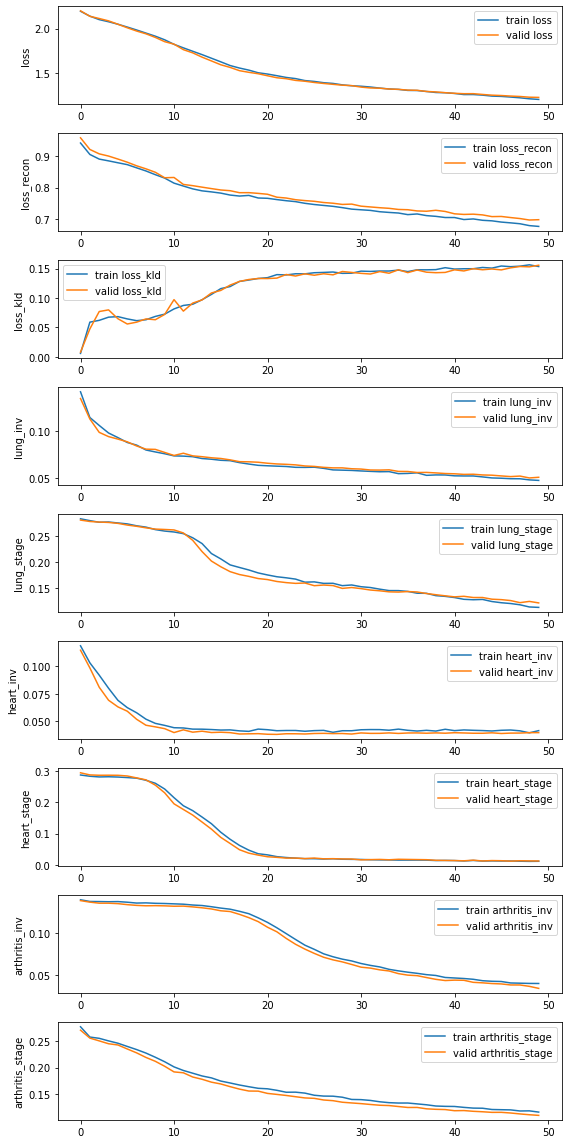

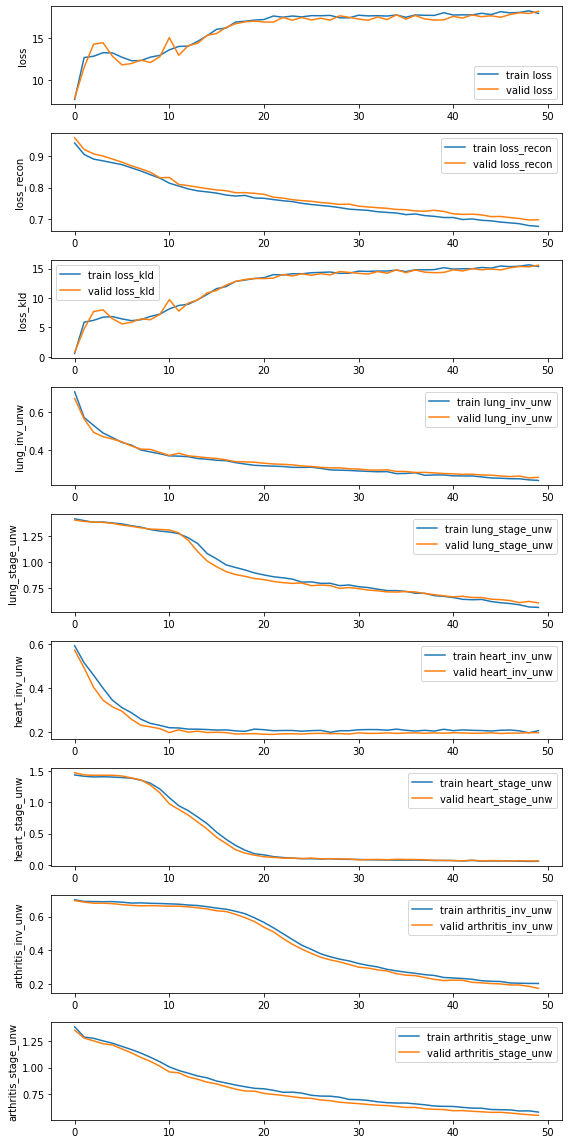

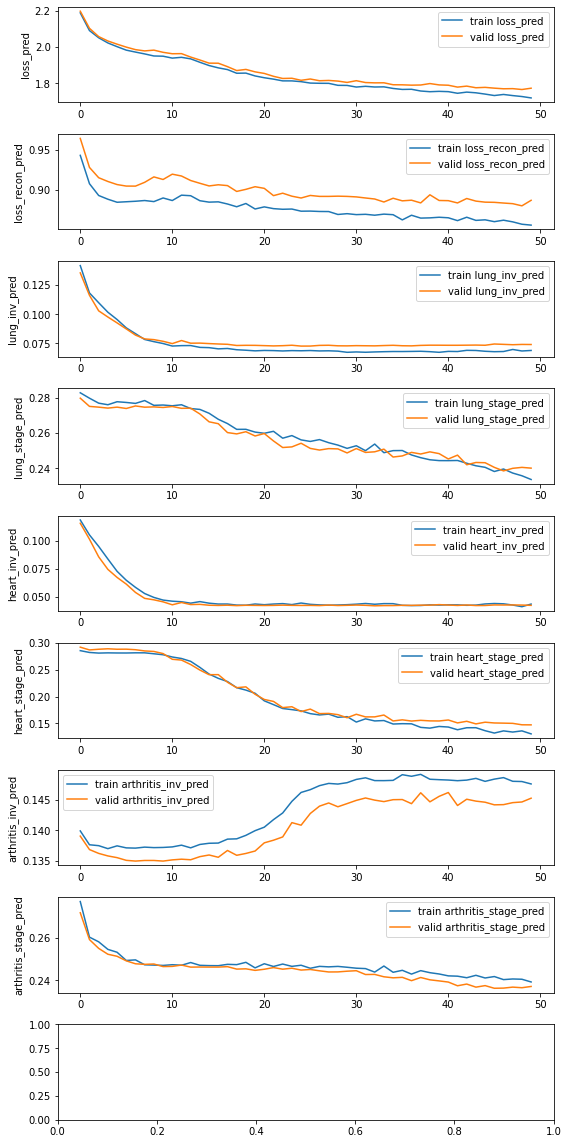

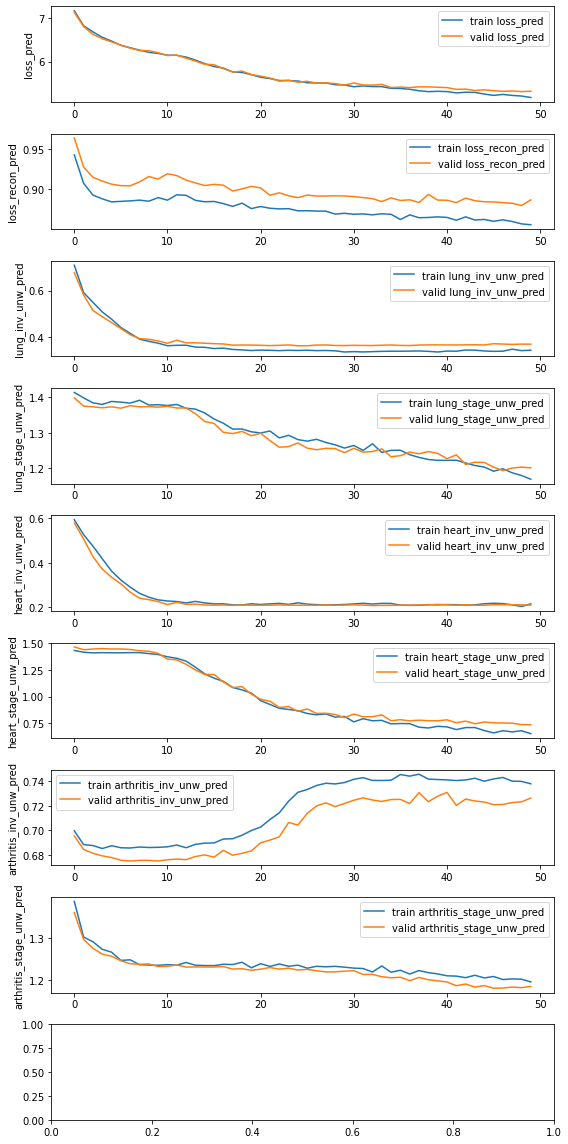

In [4]:
plot_losses(pipeline)